IMPORTANT NOTE ON SYSTEM REQUIREMENTS:

If you are connecting to a hosted runtime - run !nvidia-smi to confirm. 

Colab may first assign you a lower memory machine like a Tesla T4 GPU if you are using a hosted runtime.  If so, the first time you try to load the 5B model, it will run out of memory, and then you'll be prompted to restart with more memory (then return to the top of this Colab).  

If you continue to have memory issues after this (or run into issues on your own home setup), switch to the 1B model.

If you are using a local GPU, we recommend V100 or P100 with 16GB GPU memory for best performance. For GPU’s with less memory, we recommend using the 1B model and a smaller batch size throughout.  

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-065a23d2-ee5a-51c9-65e9-0b1fa3d0cb45)


Check against this image (you need a P100 GPU to run the best models [5b, 5b_lyrics], otherwise you can only run the 1b model series).

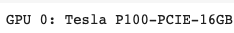

Mount Google Drive to save sample levels as they are generated.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/SMU_MITB_NLP/NLP project/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1MmY0pN1b5xL_C2CijM9ImcFM-UFt4bwr/NLP project


Prepare the environment.

In [3]:
!pip install git+https://github.com/openai/jukebox.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/jukebox.git to /tmp/pip-req-build-lyhfbev3
  Running command git clone -q https://github.com/openai/jukebox.git /tmp/pip-req-build-lyhfbev3
     |████████████████████████████████| 60 kB 7.7 MB/s 
     |████████████████████████████████| 238 kB 40.5 MB/s 
     |████████████████████████████████| 3.5 MB 79.9 MB/s 
     |████████████████████████████████| 1.6 MB 80.2 MB/s 
     |████████████████████████████████| 2.5 MB 66.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 20.2 MB 32.7 MB/s 
  Created wheel for jukebox: filename=jukebox-1.0-py3-none-any.whl size=197916 sha256=ab332fe52794fdfeaffca174ccc3bbf5b4d686351406a31afab49895a2c95205
  Stored in directory: /tmp/pip-ephem-wheel-cache-tomtbij1/wheels/d6/42/39/91f8a32505a445499702ae0f88

In [4]:
import jukebox
import torch as t
import librosa
import os
from IPython.display import Audio
from jukebox.make_models import make_vqvae, make_prior, MODELS, make_model
from jukebox.hparams import Hyperparams, setup_hparams
from jukebox.sample import sample_single_window, _sample, \
                           sample_partial_window, upsample, \
                           load_prompts
from jukebox.utils.dist_utils import setup_dist_from_mpi
from jukebox.utils.torch_utils import empty_cache
rank, local_rank, device = setup_dist_from_mpi()

Using cuda True


# Sample from the 5B or 1B Lyrics Model


The 5B model is boasts a superior performance to the 1b model, but requires Colab to minimally assign a P100 GPU.

In [5]:
model = '5b_lyrics' # or '5b' or '1b', or '1b_lyrics' Depends on the song you want.
hps = Hyperparams()
hps.sr = 44100
hps.n_samples = 3 if model in ('5b', '5b_lyrics') else 8
# Specifies the directory to save the sample in.
# We set this to the Google Drive mount point.
hps.name = '/content/drive/MyDrive/Colab Notebooks/SMU_MITB_NLP/NLP project/Generated Melody/Home_CD_Pop'
chunk_size = 16 if model in ('5b', '5b_lyrics') else 32
max_batch_size = 3 if model in ('5b', '5b_lyrics') else 16
hps.levels = 3
hps.hop_fraction = [.5,.5,.125]

vqvae, *priors = MODELS[model]
vqvae = make_vqvae(setup_hparams(vqvae, dict(sample_length = 1048576)), device)
top_prior = make_prior(setup_hparams(priors[-1], dict()), vqvae, device)

Running  wget -O /root/.cache/jukebox/models/5b/vqvae.pth.tar https://openaipublic.azureedge.net/jukebox/models/5b/vqvae.pth.tar
Restored from /root/.cache/jukebox/models/5b/vqvae.pth.tar
0: Loading vqvae in eval mode
Loading artist IDs from /usr/local/lib/python3.7/dist-packages/jukebox/data/ids/v2_artist_ids.txt
Loading artist IDs from /usr/local/lib/python3.7/dist-packages/jukebox/data/ids/v2_genre_ids.txt
Level:2, Cond downsample:None, Raw to tokens:128, Sample length:1048576
0: Converting to fp16 params
Running  wget -O /root/.cache/jukebox/models/5b_lyrics/prior_level_2.pth.tar https://openaipublic.azureedge.net/jukebox/models/5b_lyrics/prior_level_2.pth.tar
Restored from /root/.cache/jukebox/models/5b_lyrics/prior_level_2.pth.tar
0: Loading prior in eval mode


# Select mode
'Ancestral' mode means that the model generates a new song from scratch. 'Primed' mode continues from an existing song, so you need to supply a .wav file of the song you want to continue from. 

The results from 'ancestral' mode is random.

In [6]:
# The default mode of operation.
# Creates songs based on artist and genre conditioning.
mode = 'ancestral'
codes_file=None
audio_file=None
prompt_length_in_seconds=None

In [7]:
sample_hps = Hyperparams(dict(mode=mode, codes_file=codes_file, audio_file=audio_file, prompt_length_in_seconds=prompt_length_in_seconds))

Specify your choice of artist, genre, lyrics, and length of musical sample. 

IMPORTANT: The sample length is crucial for how long your sample takes to generate. Generating a shorter sample takes less time. You are limited to 12 hours on the Google Colab free tier. A 50 second sample should be short enough to fully generate after 12 hours of processing. 

In [8]:
sample_length_in_seconds = 50          # Full length of musical sample to generate - we find songs in the 1 to 4 minute
                                       # range work well, with generation time proportional to sample length.  
                                       # This total length affects how quickly the model 
                                       # progresses through lyrics (model also generates differently
                                       # depending on if it thinks it's in the beginning, middle, or end of sample)
hps.sample_length = (int(sample_length_in_seconds*hps.sr)//top_prior.raw_to_tokens)*top_prior.raw_to_tokens
assert hps.sample_length >= top_prior.n_ctx*top_prior.raw_to_tokens, f'Please choose a larger sampling rate'

In [9]:
# Note: Metas can contain different prompts per sample.
# By default, all samples use the same prompt.
metas = [dict(artist = "Céline Dion",
            genre = "Pop",
            total_length = hps.sample_length,
            offset = 0,
            lyrics = """Whenever I am feeling low
I look around me and I know
There's a place that will stay within me
Wherever I may choose to go
I will always recall the city
Know every street and shore
Sail down that river which brings us life
Winding through my Singapore

This is home, truly
Where I know I must be
Where my dreams wait for me
Where that river always flows
This is home, surely
As my senses tell me
This is where I won't be alone
For this is where I know it's home

When there are troubles to go through
We'll find a way to start anew
There is comfort in the knowledge
That home's about its people too
So we'll build our dreams together
Just like we've done before
Just like that river which brings us life
There'll always be Singapore

This is home, truly
Where I know I must be
Where my dreams wait for me
Where that river always flows
This is home, surely
As my senses tell me
This is where I won't be alone
For this is where I know it's home

This is home, truly
Where I know I must be
Where my dreams wait for me
Where that river always flows
This is home, surely
As my senses tell me
This is where I won't be alone
For this is where I know it's home
For this is where I know it's home
For this is where I know I'm home
""",
            ),
          ] * hps.n_samples
labels = [None, None, top_prior.labeller.get_batch_labels(metas, 'cuda')]

Optionally adjust the sampling temperature. A value of 1.0 means that you would like the model to stay very close to the exact musical patterns of the artist and the genre. The recommended temperature for novelty is .98 or .99. Alternatively there are some suggested temperatures (https://jukebox.openai.com/) depending on the genre and singer you're using.

max_batch_size = 3 means that we're asking the model to generate 3 music samples. We can specify for the model to generate more.


In [10]:
sampling_temperature = .98

lower_batch_size = 16
max_batch_size = 3 if model in ('5b', '5b_lyrics') else 16
lower_level_chunk_size = 32
chunk_size = 16 if model in ('5b', '5b_lyrics') else 32
sampling_kwargs = [dict(temp=.99, fp16=True, max_batch_size=lower_batch_size,
                        chunk_size=lower_level_chunk_size),
                    dict(temp=0.99, fp16=True, max_batch_size=lower_batch_size,
                         chunk_size=lower_level_chunk_size),
                    dict(temp=sampling_temperature, fp16=True, 
                         max_batch_size=max_batch_size, chunk_size=chunk_size)]

Now we're ready to sample from the model. We'll generate the top level (2) first, followed by the first upsampling (level 1), and the second upsampling (0).  In this CoLab we load the top prior separately from the upsamplers, because of memory concerns on the hosted runtimes. If using a local machine, we can also load all models directly with make_models, and then use sample.py's ancestral_sampling to put this all in one step.

After each level, we decode to raw audio and save the audio files.   

This next cell will take a while (approximately 10 minutes per 20 seconds of music sample)

In [11]:
if sample_hps.mode == 'ancestral':
  zs = [t.zeros(hps.n_samples,0,dtype=t.long, device='cuda') for _ in range(len(priors))]
  zs = _sample(zs, labels, sampling_kwargs, [None, None, top_prior], [2], hps)
elif sample_hps.mode == 'upsample':
  assert sample_hps.codes_file is not None
  # Load codes.
  data = t.load(sample_hps.codes_file, map_location='cpu')
  zs = [z.cuda() for z in data['zs']]
  assert zs[-1].shape[0] == hps.n_samples, f"Expected bs = {hps.n_samples}, got {zs[-1].shape[0]}"
  del data
  print('Falling through to the upsample step later in the notebook.')
elif sample_hps.mode == 'primed':
  assert sample_hps.audio_file is not None
  audio_files = sample_hps.audio_file.split(',')
  duration = (int(sample_hps.prompt_length_in_seconds*hps.sr)//top_prior.raw_to_tokens)*top_prior.raw_to_tokens
  x = load_prompts(audio_files, duration, hps)
  zs = top_prior.encode(x, start_level=0, end_level=len(priors), bs_chunks=x.shape[0])
  zs = _sample(zs, labels, sampling_kwargs, [None, None, top_prior], [2], hps)
else:
  raise ValueError(f'Unknown sample mode {sample_hps.mode}.')

Sampling level 2
Sampling 8192 tokens for [0,8192]. Conditioning on 0 tokens
Ancestral sampling 3 samples with temp=0.98, top_k=0, top_p=0.0
8192/8192 [14:02<00:00,  9.73it/s]
Sampling 8192 tokens for [1024,9216]. Conditioning on 7168 tokens
Primed sampling 3 samples with temp=0.98, top_k=0, top_p=0.0
448/448 [01:37<00:00,  4.62it/s]
1024/1024 [02:06<00:00,  8.08it/s]
Sampling 8192 tokens for [2048,10240]. Conditioning on 7168 tokens
Primed sampling 3 samples with temp=0.98, top_k=0, top_p=0.0
448/448 [01:36<00:00,  4.63it/s]
1024/1024 [02:07<00:00,  8.06it/s]
Sampling 8192 tokens for [3072,11264]. Conditioning on 7168 tokens
Primed sampling 3 samples with temp=0.98, top_k=0, top_p=0.0
448/448 [01:36<00:00,  4.63it/s]
1024/1024 [02:07<00:00,  8.06it/s]
Sampling 8192 tokens for [4096,12288]. Conditioning on 7168 tokens
Primed sampling 3 samples with temp=0.98, top_k=0, top_p=0.0
448/448 [01:36<00:00,  4.63it/s]
1024/1024 [02:06<00:00,  8.06it/s]
Sampling 8192 tokens for [5120,13312]. Co

Code to listen to the results at the top level. This will sound very noisy until we do the upsampling stage. 'item_0' refers to the very first song sample generated.

In [12]:
Audio(f'{hps.name}/level_2/item_0.wav')

Output hidden; open in https://colab.research.google.com to view.

In [13]:
Audio(f'{hps.name}/level_2/item_1.wav')

Output hidden; open in https://colab.research.google.com to view.

In [14]:
Audio(f'{hps.name}/level_2/item_2.wav')

Output hidden; open in https://colab.research.google.com to view.

We are now done with the large top_prior model, and instead load the upsamplers.

In [15]:
# Set this False if you are on a local machine that has enough memory (this allows you to do the
# lyrics alignment visualization during the upsampling stage). For a hosted runtime, 
# we'll need to go ahead and delete the top_prior if you are using the 5b_lyrics model.
if True:
  del top_prior
  empty_cache()
  top_prior=None
upsamplers = [make_prior(setup_hparams(prior, dict()), vqvae, 'cpu') for prior in priors[:-1]]
labels[:2] = [prior.labeller.get_batch_labels(metas, 'cuda') for prior in upsamplers]

Conditioning on 1 above level(s)
Checkpointing convs
Checkpointing convs
Loading artist IDs from /usr/local/lib/python3.7/dist-packages/jukebox/data/ids/v2_artist_ids.txt
Loading artist IDs from /usr/local/lib/python3.7/dist-packages/jukebox/data/ids/v2_genre_ids.txt
Level:0, Cond downsample:4, Raw to tokens:8, Sample length:65536
Running  wget -O /root/.cache/jukebox/models/5b/prior_level_0.pth.tar https://openaipublic.azureedge.net/jukebox/models/5b/prior_level_0.pth.tar
Restored from /root/.cache/jukebox/models/5b/prior_level_0.pth.tar
0: Loading prior in eval mode
Conditioning on 1 above level(s)
Checkpointing convs
Checkpointing convs
Loading artist IDs from /usr/local/lib/python3.7/dist-packages/jukebox/data/ids/v2_artist_ids.txt
Loading artist IDs from /usr/local/lib/python3.7/dist-packages/jukebox/data/ids/v2_genre_ids.txt
Level:1, Cond downsample:4, Raw to tokens:32, Sample length:262144
Running  wget -O /root/.cache/jukebox/models/5b/prior_level_1.pth.tar https://openaipublic

This next upsampling step will take several hours.  

Note: At the free tier, Google Colab only allows a max run of 12 hours.  As the upsampling is completed, samples will appear in the Files tab (you can access this at the left of the Colab), under "samples" (or whatever hps.name is currently).  Level 1 is the partially upsampled version, Level 0 is the fully completed version.

In [16]:
zs = upsample(zs, labels, sampling_kwargs, [*upsamplers, top_prior], hps)

Sampling level 1
Sampling 8192 tokens for [0,8192]. Conditioning on 0 tokens
Ancestral sampling 3 samples with temp=0.99, top_k=0, top_p=0.0
8192/8192 [08:46<00:00, 15.56it/s]
Sampling 8192 tokens for [4096,12288]. Conditioning on 4096 tokens
Primed sampling 3 samples with temp=0.99, top_k=0, top_p=0.0
128/128 [00:09<00:00, 13.13it/s]
4096/4096 [04:21<00:00, 15.67it/s]
Sampling 8192 tokens for [8192,16384]. Conditioning on 4096 tokens
Primed sampling 3 samples with temp=0.99, top_k=0, top_p=0.0
128/128 [00:09<00:00, 13.26it/s]
4096/4096 [04:22<00:00, 15.59it/s]
Sampling 8192 tokens for [12288,20480]. Conditioning on 4096 tokens
Primed sampling 3 samples with temp=0.99, top_k=0, top_p=0.0
128/128 [00:09<00:00, 13.26it/s]
4096/4096 [04:22<00:00, 15.60it/s]
Sampling 8192 tokens for [16384,24576]. Conditioning on 4096 tokens
Primed sampling 3 samples with temp=0.99, top_k=0, top_p=0.0
128/128 [00:09<00:00, 13.22it/s]
4096/4096 [04:21<00:00, 15.65it/s]
Sampling 8192 tokens for [20480,28672]

Listen to the final sample!

In [17]:
Audio(f'{hps.name}/level_0/item_0.wav')

Output hidden; open in https://colab.research.google.com to view.

In [18]:
Audio(f'{hps.name}/level_0/item_1.wav')

Output hidden; open in https://colab.research.google.com to view.

In [19]:
Audio(f'{hps.name}/level_0/item_2.wav')

Output hidden; open in https://colab.research.google.com to view.

In [20]:
del upsamplers
empty_cache()